# Detecting weather anomalies using ARMA processes
## Runar Helin

In [1]:
import requests
import io
from pprint import pprint
import datetime

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

import statsmodels.api as sm

## Let us prepare the dataset
Today we will analyse weather data from Ås; more specifically, we will analyse temperature data.

In [2]:
X = pd.read_csv('data/weather.csv', index_col=0)
X.index = pd.to_datetime(X.index)
X.index.freq = X.index.inferred_freq    # Set the frequency of the timeseries data to infered freqyency

y = X['Maksimum lufttemperatur i 2m hoyde (TX)']

# Cannot do random split on time series data
split_idx = y.index[len(y)//2]
y_train = y[:split_idx]
y_test = y[split_idx:]

In [3]:
X.index.freq

<Day>

## Before we train, we plot our data

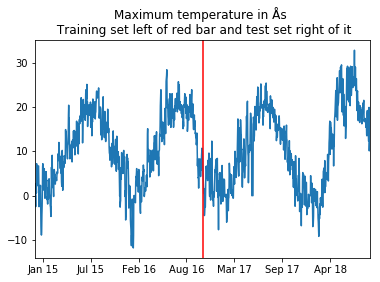

In [8]:
fig = plt.figure()
sub = fig.add_subplot(111)

date_idx = mdates.date2num(y.index)#.to_pydatetime())
sub.plot(date_idx, y)
ylim = sub.get_ylim()
sub.plot(2*[mdates.date2num(split_idx)], ylim, 'r')

# Make x-axis dates
month_format = mdates.DateFormatter("%b %y")
sub.xaxis.set_major_formatter(month_format)

sub.set_title('Maximum temperature in Ås \n Training set left of red bar and test set right of it')
sub.set_xlim(date_idx[0], date_idx[-1])
sub.set_ylim(ylim)

plt.show()

## Let's find some outliers!

In [5]:
# We use a SARIMAX model, which is a more complicated version of ARMA,
# We can, however, use an ARMA model by setting the correct parameters.
# We do this because the ARMA model doesn't support testing on new datasets
arma = sm.tsa.SARIMAX(y_train, order=(5, 0, 1))
results = arma.fit()

# Create model for testing and copy parameters
test_model = sm.tsa.SARIMAX(y_test, order=(5, 0, 1))
test_results = test_model.smooth(results.params)

In [6]:
test_prediction = test_results.predict()
test_error = test_prediction - y_test
MAE = np.median(np.abs(test_error))

print(f'The test median absolute error is {MAE}')

# We say that the outliers have an error more than two times the MAE
outliers = np.abs(test_error) > 3*MAE

The test median absolute error is 1.6368316577700965


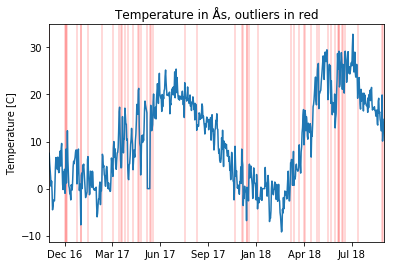

In [9]:
fig = plt.figure()
sub = plt.subplot()


date_index = mdates.date2num(y_test.index.to_pydatetime())
sub.plot(date_index, y_test)

outlier_dates = outliers.index[outliers]
col = [((mdates.date2num(date), -40), (mdates.date2num(date), 40)) for date in outlier_dates]
sub.add_collection(LineCollection(col, color=(1,0,0,0.2)))

# Make x-axis dates
month_format = mdates.DateFormatter("%b %y")
sub.xaxis.set_major_formatter(month_format)
sub.set_xlim(date_index[0], date_index[-1])

sub.set_title('Temperature in Ås, outliers in red')
sub.set_ylabel('Temperature [C]')
plt.show()